In [1]:
import scipy.io as sio
import numpy as np
import os
import pandas as pd

import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Source Data

Paper [link](https://www.nature.com/articles/s41467-021-24336-w)

Github repo [link](https://github.com/alxdroR/SRNatComm21)


Lab Current Code : https://github.com/alxdroR/zfOcMotor/tree/greg

## Loading main data

In [2]:
base_dir = "/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging"
traces = os.path.join(base_dir, "CaTracesAndFootprints/")
behavior = os.path.join(base_dir, "behavior10to20Hz/")


In [3]:
muf = sio.loadmat(traces + "f1_traces_EPSelect.mat")
muf.keys()

dict_keys(['__header__', '__version__', '__globals__', 'expMetaData', 'filenames', 'fluorescence', 'filtFl', 'frate', 'Por', 'b2', 'f2', 'localCoordinates', 'A', 'twitchFrames', 'twitchTimes', 'MCerror', 'syncOffset', 'cellSelectParam'])

In [3]:
class zfSessionData:
    def __init__(self, fish=[], method='ep'):
        self.base_dir = "/Users/samart/Documents/Geometric DA/Final Project/RamirezPaperData/analyzedBehaviorAndImaging"        
        self.traces = os.path.join(self.base_dir, "CaTracesAndFootprints/")
        self.behavior = os.path.join(self.base_dir, "behavior10to20Hz/")
        # A is output of CaImAn, Gaussian Centered around cell locations
        # A binary is a binary mask that tells where cells are; A itself pretty much useless

        EP = [s for s in os.listdir(self.traces) if "traces_EPSelect" in s] # CaImAN
        IM = [s for s in os.listdir(self.traces) if "traces_IMOpenSelect" in s] # avg intensity
        self.files = EP if method == 'ep' else IM
        self.method = method.lower()
        self.fish_names = [s.split('_')[0] for s in self.files]
        self.fish_names.sort()
        
        self.data = {}     
        for f in fish:
            print(f"Parsing {f} data")
            self.parse_trace(f)

    def get_filename(self, fish):
        if(self.method == 'ep'):
            return(f"{fish}_traces_EPSelect.mat")
        elif(self.method == 'im'):
            return(f"{fish}_traces_IMOpenSelect.mat")
        
    def parse_trace(self, fish):
        filename = self.get_filename(fish)
        data = sio.loadmat(os.path.join(self.traces, filename))
        cellLocs = [file[0] for file in data['localCoordinates']]
        fluor = [file[0] for file in data['fluorescence']]
        num_samples = fluor[0].shape[1] # num_cells x num_samples
        file_data = {
            'fluor' : fluor,
            'cellLocations' : cellLocs,
            'num_samples' : num_samples,
        }
        self.data[fish] = file_data
        return(data)

    def load_behavior(self, fish, idx):
        fname = os.path.join(self.behavior, f"{fish}_{idx}.mat")
        data = sio.loadmat(fname)
        return(data)
    
    def load_trajectory(self, fish, idx):
        # idx belongs to different OG tiff files (RHB vs non RHB?), likely z planes
        fluor = self.data[fish]['fluor'][idx]
        loc = self.data[fish]['cellLocations'][idx]
        # dF/F
        temporal_mean = np.mean(fluor, axis=1).reshape(-1, 1)
        dFF = (fluor - temporal_mean) / temporal_mean

        N, t = dFF.shape
        da = xr.DataArray(dFF, dims=('N', 'T'), coords={'N' : np.arange(1, N+1), 'T' : np.arange(0, t), 
                                                        'X' : (('N',), loc[:,0]), 'Y' : (('N',), loc[:,1])})
        
        return(da)

In [4]:
zf = zfSessionData(['f1'])

Parsing f1 data


In [5]:
zf.data['f1']['cellLocations'][2]

array([[107.97604999, 364.92869762],
       [138.32277128, 502.39136487],
       [136.56898413, 474.74172388],
       [ 88.54069708, 361.15932442],
       [ 87.25638037,  57.33936519],
       [  5.45634071, 133.79771293],
       [ 53.15621192,  47.39353067],
       [395.62413975, 222.82432957],
       [ 80.22708233, 144.62048729],
       [163.92881355, 503.4435264 ],
       [ 72.92984497, 375.61033943],
       [180.58536061, 116.87960927],
       [ 21.68323116, 200.54244648],
       [ 28.9400884 , 283.05210672],
       [152.40205032, 241.95009976],
       [370.92001341, 211.59557526],
       [ 73.62499306, 300.0179954 ],
       [128.4813555 , 228.20469686],
       [105.39954884, 375.51948791],
       [126.09924068, 503.2584571 ],
       [ 48.25119603, 249.51351441],
       [ 75.69647059, 365.64569234],
       [443.29316467, 503.98191224],
       [ 89.11786736, 373.13185466],
       [  7.70346049, 150.70917825],
       [ 12.51850616, 272.2477415 ],
       [140.88535712, 223.683953  ],
 

In [6]:
trajectory = zf.load_trajectory('f1', 5)
trajectory

<xarray.DataArray (N: 217, T: 234)>
array([[ 1.34475294e+00,  1.63932110e+00,  2.41911423e-02, ...,
        -8.12626855e-02, -5.89699090e-02,  5.04013742e-03],
       [ 7.91648975e-01,  9.71706554e-01,  5.50518296e-01, ...,
        -9.57790304e-02, -4.79528545e-02, -2.77173271e-02],
       [ 1.92209472e+00,  1.71500996e+00,  7.64923639e-02, ...,
        -2.59560942e-02, -3.19786792e-02,  4.16475605e-02],
       ...,
       [ 1.90971591e+00,  2.35363957e+00,  2.18652081e-01, ...,
        -7.82914683e-02,  5.67942502e-02, -8.85319473e-04],
       [ 2.41204772e+00,  2.33918624e+00,  1.08946152e-01, ...,
         9.10983513e-03,  8.98055545e-02,  1.49998135e-01],
       [ 2.25467161e+00,  2.14468769e+00,  7.16177997e-01, ...,
        -1.20528876e-01, -7.73655966e-02, -4.11052082e-02]])
Coordinates:
  * N        (N) int64 1 2 3 4 5 6 7 8 9 ... 209 210 211 212 213 214 215 216 217
  * T        (T) int64 0 1 2 3 4 5 6 7 8 ... 225 226 227 228 229 230 231 232 233
    X        (N) float64 38.95 152.7 342.8 161.8 ... 125.4 97.22 423.7 420.8
    Y        (N) float64 288.8 158.3 449.5 482.6 ... 486.3 469.5 394.8 449.4

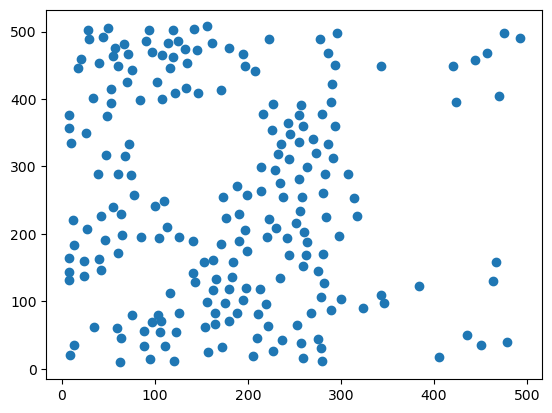

In [7]:
plt.scatter(trajectory.X, trajectory.Y)

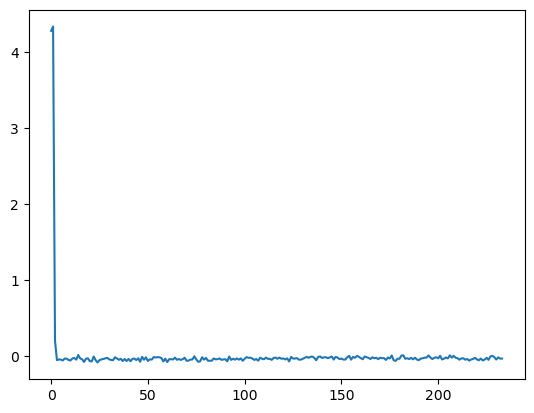

In [8]:
plt.plot(trajectory.sel(N=8))

## Segmenting by Behavior

In [16]:
behavior_files = os.listdir(zf.behavior)
behavior_files.sort()
behavior_files

['f11_1.mat',
 'f11_10.mat',
 'f11_11.mat',
 'f11_2.mat',
 'f11_3.mat',
 'f11_4.mat',
 'f11_5.mat',
 'f11_6.mat',
 'f11_7.mat',
 'f11_8.mat',
 'f11_9.mat',
 'f12_1.mat',
 'f12_10.mat',
 'f12_11.mat',
 'f12_2.mat',
 'f12_3.mat',
 'f12_4.mat',
 'f12_5.mat',
 'f12_6.mat',
 'f12_7.mat',
 'f12_8.mat',
 'f12_9.mat',
 'f13_1.mat',
 'f13_10.mat',
 'f13_11.mat',
 'f13_12.mat',
 'f13_13.mat',
 'f13_14.mat',
 'f13_15.mat',
 'f13_16.mat',
 'f13_17.mat',
 'f13_18.mat',
 'f13_19.mat',
 'f13_2.mat',
 'f13_20.mat',
 'f13_21.mat',
 'f13_22.mat',
 'f13_23.mat',
 'f13_24.mat',
 'f13_3.mat',
 'f13_4.mat',
 'f13_5.mat',
 'f13_6.mat',
 'f13_7.mat',
 'f13_8.mat',
 'f13_9.mat',
 'f14_1.mat',
 'f14_10.mat',
 'f14_11.mat',
 'f14_12.mat',
 'f14_13.mat',
 'f14_14.mat',
 'f14_15.mat',
 'f14_16.mat',
 'f14_17.mat',
 'f14_18.mat',
 'f14_19.mat',
 'f14_2.mat',
 'f14_20.mat',
 'f14_21.mat',
 'f14_22.mat',
 'f14_23.mat',
 'f14_24.mat',
 'f14_25.mat',
 'f14_26.mat',
 'f14_27.mat',
 'f14_28.mat',
 'f14_29.mat',
 'f14_3.m

In [17]:
def load_behavior(self, fish, idx):
    fname = os.path.join(self.behavior, f"{fish}_{idx}.mat")
    data = sio.loadmat(fname)
    return(data)

In [20]:
B = load_behavior(zf, 'f1', 5)


In [21]:
B['eye_prop'].shape
B['eye_prop'][0]

array([array([[(array([[162.02041858, 199.40451993]]), array([[-135.61016914]]), array([[235.71649778]]), array([[161.19959408]])),
               (array([[393.64340036, 336.17090468]]), array([[-109.08530396]]), array([[243.41814676]]), array([[165.16358682]]))]],
             dtype=[('Centroid', 'O'), ('Orientation', 'O'), ('MajorAxisLength', 'O'), ('MinorAxisLength', 'O')])                    ,
       array([[(array([[162.03615188, 199.24071745]]), array([[-135.34934946]]), array([[236.17541539]]), array([[160.68221268]])),
               (array([[393.76149547, 336.18613499]]), array([[-108.6526435]]), array([[244.16368254]]), array([[164.80649698]]))]],
             dtype=[('Centroid', 'O'), ('Orientation', 'O'), ('MajorAxisLength', 'O'), ('MinorAxisLength', 'O')])                   ,
       array([[(array([[161.9837167 , 199.02136892]]), array([[-135.55798251]]), array([[235.39496082]]), array([[161.11431259]])),
               (array([[393.69662868, 336.28317167]]), array([[-108.

In [22]:
B['leye_position'].shape

(2, 3622)

In [23]:
B.keys()

dict_keys(['__header__', '__version__', '__globals__', 'leye_position', 'reye_position', 'eye_prop', 'bodyCentroid'])

In [25]:
zf.fish_names[:10]

['f1', 'f11', 'f12', 'f13', 'f14', 'f16', 'f3', 'f4', 'f6', 'f7']

# Compute Simplicial Complex

In [5]:
import gudhi
from sklearn.cluster import SpectralClustering

In [7]:
T1 = zf.load_trajectory('f1', 2)
T1 = T1.sel(N=slice(0, 20), T=slice(10, 30))
n, t = T1.shape
n, t

(20, 21)

In [8]:
T2 = T1 + np.random.randn(n, t) / 2
(T1 - T2).max()

<xarray.DataArray ()>
array(1.60950546)

In [82]:
class SimplicialComplex:
    def __init__(self, trajectories):
        """
        Input: 
            trajectories is a list of neural time series of N dimensional vectors (Nxti) matrix). Each time series is xarray data array
            Time Series assumed to lie on k<N dimensional manifold
            Time series length does not have to be the same, N has to be same for trajectories to exist in same space
            I matrices of size N by Ti 
        """
        self.N = trajectories[0].shape[0]
        self.trajectories = trajectories
        self.vertices = []
        self.edges = set()
        self.pairwise_distances = -1
        self.graph = -1
        self.simplices = -1 # for k>=2
        
        for t in trajectories:
            self.add_trajectory(t)

    def reset(self):
        self.pairwise_distances = -1
        self.graph = -1
        self.simplices = -1 # for k>=2

    def construct_simplex(self, epsilon):
        self.compute_pairwise_distances()
        self.connect_edges(epsilon)
        self.form_k_simplices(epsilon)

    def add_trajectory(self, trajectory, connect_frames=True):
        N, T = trajectory.shape
        assert N == self.N, "trajectory dimensionality does not match" 
        for i, t in enumerate(trajectory['T']):
            v = trajectory.sel(T=t).data
            v_index = len(self.vertices)
            self.vertices.append(v)
            if(i > 0 and connect_frames): # connect to previous state vector in trajectory
                self.edges.add((v_index-1, v_index))
        self.pairwise_distances = -1 # reset
        self.graph = -1
    
    def compute_pairwise_distances(self):
        vertices = np.array(self.vertices)
        V, D = vertices.shape
        pairwise_diff = vertices[:, np.newaxis, :] - vertices[np.newaxis, :, :]
        pairwise_distances = np.linalg.norm(pairwise_diff, axis=2)
        self.pairwise_distances = pairwise_distances
        
    def connect_edges(self, epsilon, add=True):
        new_edges = []
        if(type(self.pairwise_distances) == int):
            self.compute_pairwise_distances()
        row_indices, col_indices = np.where(self.pairwise_distances < epsilon)
        for i, j in zip(row_indices, col_indices):
            if(i!=j):
                new_edges.append((i,j))
        if(add):
            self.edges = self.edges.union(set(new_edges))
        return(new_edges)

    def form_k_simplices(self, epsilon):
        assert len(self.vertices) > 0, "Construct graph first"
        assert len(self.edges) > 0, "Construct graph first"
        graph = nx.Graph()
        for i in range(len(self.vertices)):
            graph.add_node(i, vector=vertices[i])
        graph.add_edges_from(self.edges)
        cliques = nx.find_cliques(graph)
        extract_simplices = {}
        for c in cliques:
            k = len(c)
            if(k>2): 
                if(k not in extract_simplices.keys()):
                    extract_simplices[k] = []
                extract_simplices[k].append(c)
        self.simplices = extract_simplices
        self.graph = graph
        return(graph, extract_simplices)

    def draw(self):
        nx.draw(self.graph, with_labels=True, node_color='skyblue', node_size=200, font_size=12)
        plt.show()

    def persist_precomputed(self, k, plot = True):
        if(type(self.pairwise_distances) == int):
            pairwise_distances = self.compute_pairwise_distances() 
        rc = gudhi.RipsComplex(distance_matrix = pairwise_distances)
        st = rc.create_simplex_tree(max_dimension=k)   
        diagram = st.persistence()
        if plot:
            gudhi.plot_persistence_diagram(diagram)
            plt.show()
        return diagram, st
            
    def boundary_matrix(self):
        pass

In [83]:
X = SimplicialComplex([T1, T2])
len(X.vertices), len(X.edges)

(42, 40)

In [84]:
X.construct_simplex(1.5)

In [85]:
X.simplices

{20: [[15, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 14]],
 3: [[15, 17, 16]]}

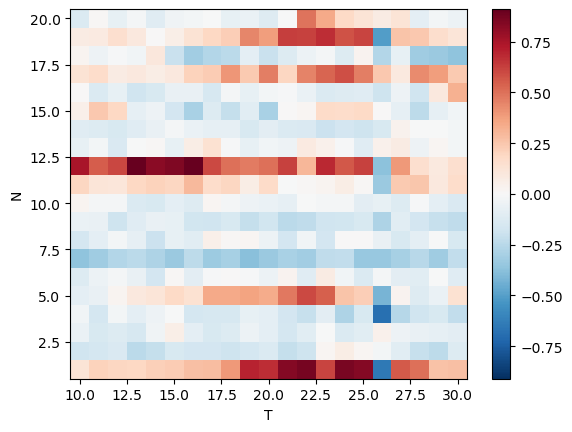

In [96]:
T1.plot()

In [93]:
times = T1['T']
dists = []
for i in range(len(times)-1):
    v, v_next = T1.isel(T=i), T1.isel(T=i+1)
    dists.append(np.linalg.norm(v-v_next))

dists

[0.41963661568218125,
 0.3077655522178241,
 0.5037436802270706,
 0.3080106153132589,
 0.4565586999092291,
 0.41284653017386885,
 0.5116032421692294,
 0.3363982474622971,
 0.5126639230871983,
 0.3816920582227738,
 0.6246321118494091,
 0.7117861668024615,
 0.6391958322559724,
 0.5543324982490815,
 0.34139073472596376,
 2.3586401962574652,
 1.8843730886832006,
 0.6414854350570189,
 0.49457922937285215,
 0.436327576991057]

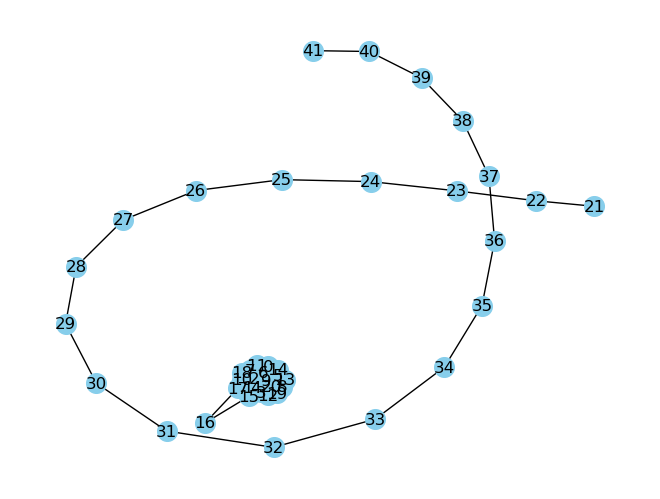

In [86]:
X.draw()

### Graph Tacs

In [21]:
import networkx as nx

In [18]:
X.connect_edges(1.5)
vertices = X.vertices
edges = X.edges

In [20]:
len(vertices), len(edges)

(42, 402)

In [22]:
graph = nx.Graph()
graph

In [29]:
graph.nodes[10]['vector'].shape

(20,)

In [62]:
cliques = nx.find_cliques(graph)

In [65]:
edges

{(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 17),
 (0, 18),
 (0, 19),
 (0, 20),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 17),
 (4, 18),
 (4, 19),
 (4, 20),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5,

In [64]:
extract_simplices

{20: [[15, 17, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18, 19, 20, 14]],
 3: [[15, 17, 16]],
 2: [[21, 22],
  [22, 23],
  [23, 24],
  [24, 25],
  [25, 26],
  [26, 27],
  [27, 28],
  [28, 29],
  [29, 30],
  [30, 31],
  [31, 32],
  [32, 33],
  [33, 34],
  [34, 35],
  [35, 36],
  [36, 37],
  [37, 38],
  [38, 39],
  [39, 40],
  [40, 41]]}

## Persistent Homology

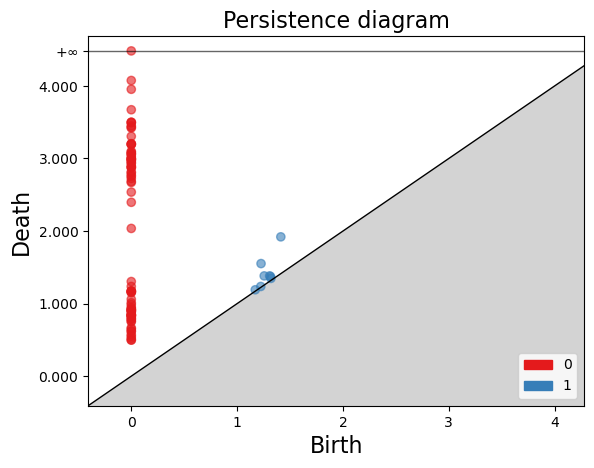

In [25]:
diagam, simplex_tree = X.persist_precomputed(3)

In [29]:
dists = X.compute_pairwise_distances()
dists

array([[0.        , 0.57349036, 0.65840054, ..., 3.4911402 , 3.75260197,
        3.34630335],
       [0.57349036, 0.        , 0.49801565, ..., 3.46380925, 3.75024862,
        3.25692368],
       [0.65840054, 0.49801565, 0.        , ..., 3.38947458, 3.69809969,
        3.26844962],
       ...,
       [3.4911402 , 3.46380925, 3.38947458, ..., 0.        , 4.01152071,
        4.38547023],
       [3.75260197, 3.75024862, 3.69809969, ..., 4.01152071, 0.        ,
        4.67002175],
       [3.34630335, 3.25692368, 3.26844962, ..., 4.38547023, 4.67002175,
        0.        ]])

In [34]:
i = 2
np.where(dists[i, i+1:] < 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 14, 15, 16, 17, 18, 19,
        20, 29, 30, 31, 32, 33, 34, 35, 36, 37]),)

In [35]:
dists[i, i+1:]

array([1.17995348, 1.45039407, 1.60482233, 1.65393502, 1.53561934,
       1.7486655 , 1.78616932, 1.50643999, 1.5401123 , 1.93974134,
       2.26613713, 2.18424423, 1.48996839, 2.08316343, 0.97980635,
       1.37030407, 1.69142126, 1.6526694 , 1.71101962, 1.87658025,
       1.91683568, 2.272136  , 2.56948204, 2.77639921, 2.84299438,
       2.71457203, 2.7703281 , 2.51349036, 2.05320489, 1.75858648,
       1.49201337, 1.58488506, 1.78927767, 1.67598013, 1.77275107,
       1.78683886, 1.44940274, 1.42807464, 2.78306396, 2.81550843,
       2.99122636, 3.89086371, 3.2931475 , 3.49736125, 3.64939344,
       3.40331145, 3.88698702, 4.31091633, 3.59040174, 3.66606541,
       3.66847225, 4.34422717, 3.24916106, 3.24701374, 4.109561  ,
       2.94507151, 4.12372592, 3.33126851, 2.62954611, 3.3871806 ,
       3.200731  , 3.35778801, 3.65079989, 4.51996575, 4.53337335,
       3.05065988, 4.2903906 , 3.89643109, 4.03307833, 3.78425343,
       4.262654  , 3.51770088, 3.60648789, 3.71966254, 3.87623

In [32]:


def persist_complex(S, E, plot = True):
    st = gudhi.SimplexTree()

    for i in range(len(S)):

        n = len(S[i][0])

        filtration_val = np.ones((n, ))*E[i]
        st.insert_batch(S[i], filtration_val)

    diagram = st.persistence()
    if plot:
        gudhi.plot_persistence_diagram(diagram)
        plt.show()
    return diagram, st


In [34]:
persist_precomputed(dists, 5)

TypeError: create_simplex_tree() got an unexpected keyword argument 'max_dimensions'

In [30]:
rc

In [25]:
edges = X.connect_edges(epsilon=3)
print(len(X.edges))

NameError: name 'X' is not defined

In [144]:
X.pairwise_distances

array([[        inf,  1.72475681,  2.30785968,  6.91210919,  7.58642893,
         7.14869063],
       [ 1.72475681,         inf,  1.94696002,  7.02451582,  7.24812041,
         7.2019686 ],
       [ 2.30785968,  1.94696002,         inf,  7.24112087,  7.6642744 ,
         6.97137549],
       [ 6.91210919,  7.02451582,  7.24112087,         inf, 10.41200586,
        10.16389849],
       [ 7.58642893,  7.24812041,  7.6642744 , 10.41200586,         inf,
        10.51592152],
       [ 7.14869063,  7.2019686 ,  6.97137549, 10.16389849, 10.51592152,
                inf]])

In [145]:
np.linalg.norm(X.vertices[3] -  X.vertices[1])

7.024515815464485

In [152]:
dists = X.pairwise_distances.flatten()
dists

array([        inf,  1.72475681,  2.30785968,  6.91210919,  7.58642893,
        7.14869063,  1.72475681,         inf,  1.94696002,  7.02451582,
        7.24812041,  7.2019686 ,  2.30785968,  1.94696002,         inf,
        7.24112087,  7.6642744 ,  6.97137549,  6.91210919,  7.02451582,
        7.24112087,         inf, 10.41200586, 10.16389849,  7.58642893,
        7.24812041,  7.6642744 , 10.41200586,         inf, 10.51592152,
        7.14869063,  7.2019686 ,  6.97137549, 10.16389849, 10.51592152,
               inf])